This notebook is written by Mert Atagül.
Purpose of this notebook is to analyze the data and make a classification model on given dataset about default of credit card clients.

On the first part of notebook I analyze and check the integrity of the data. There are no missing values. There are values that are not within the given range. There seems to be no outliers, just people with varying economic status. With a little research I find out actual range for PAY columns is actually -2 to 8. Where -2 stands for no consumption and rest is as it is given on data source (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). I move the uncategorized education values to 'other' category of education.

Then I plot a correlation matrix to see correlation between features and target. It appears that PAY features are the most important features we have.

I wanted to build a classification model immediately and get some insight. So I could improve on that models later on. I split the data into train and test (67-33). Train and get accuracy scores on those classification methods; 

KNeighborsClassifier    %76.3
AdaBoostClassifier      %81.6
RandomForestClassifier  %81.6
DecisionTreeClassifier  %71.4

While those accuracy scores seem fine they are not reliable because as I have seen while exploring the data %88 of the data is within one class. It is a very unbalanced dataset. Accuracy is not a great metric to work with here. I try out other metrics such as f1-score and roc-auc score.

f1 scores:
         knn  randomforest  adaboost  decision
0  0.165419      0.420077  0.431875  0.374917 

ROC AUC scores:
        knn  randomforest  adaboost  decision
0  0.52761      0.631869  0.637221  0.597724

It appears that randomforest and adaboost are most successful candidates so I'll be working on those two models to improve. While they are better than the rest they are still not really succesful, only slightly better than random guessing.

There are 9 categorical features on the dataset. One hot encoding those might improve the performance of the model so I try that. Unfortunately, it slightly improves adaboost model while totally ruining the randomforest one.

To demonstrate feature engineering, with very little to no domain knowledge I try to create a feature. I calculate the percentage of bill that clients pay each interval and add that as new features. Unfortunately again results did not improve, feature importances graph shows as that new features really did not weight that much in the model. Another feature I tried is pay slope which is calculated by polyfitting pay_0, pay_2, pay_3, pay_4, pay_5 features and getting that polynoms slope in order to see if trend is increasing or not. If trend is increasing client is constantly getting behind on his/her payment or vice versa. Considering strong feature importance of pay_ features I expected it to perform well. It did increase performance of randomforest classifier by significant amount but did nothing on adaboost.

To solve the major problem of unbalance that we have here I tried to downsample the dataset. We have 23364 of class zero and 6636 of class one rows. Random samples from class zero are chosen and removed to make it an even dataset with 6636 rows of class zero and class one. When I trained that downsampled dataset results did improve.

f1 scores:
    randomforest  adaboost
0       0.67539   0.67653 

ROC AUC scores:
    randomforest  adaboost
0      0.704409   0.70445

accuracy scores:
Randomforest=  0.7136986301369863 
Adaboost=  0.7077625570776256

Downsampling did help with solving the problem overfitting the model but made us lose lots of data in the process. Adding new features to the downsampled data did not improve performance either.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


main_df = pd.read_excel(r'C:\Users\atagu\OneDrive\Masaüstü\data\data.xls')
main_df.rename(columns=main_df.iloc[0],inplace=True)
main_df = main_df[1:]
main_df = main_df.astype(int)

In [2]:
main_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
main_df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


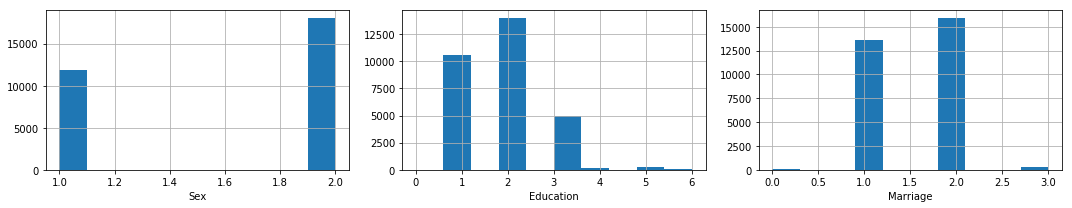

In [4]:
fig, axs = plt.subplots(1,3,figsize=(15,3))
main_df['SEX'].hist(ax = axs[0])
main_df['EDUCATION'].hist(ax = axs[1])
main_df['MARRIAGE'].hist(ax = axs[2])
axs[0].set_xlabel("Sex")
axs[1].set_xlabel("Education")
axs[2].set_xlabel("Marriage")
fig.tight_layout()
fig.show()

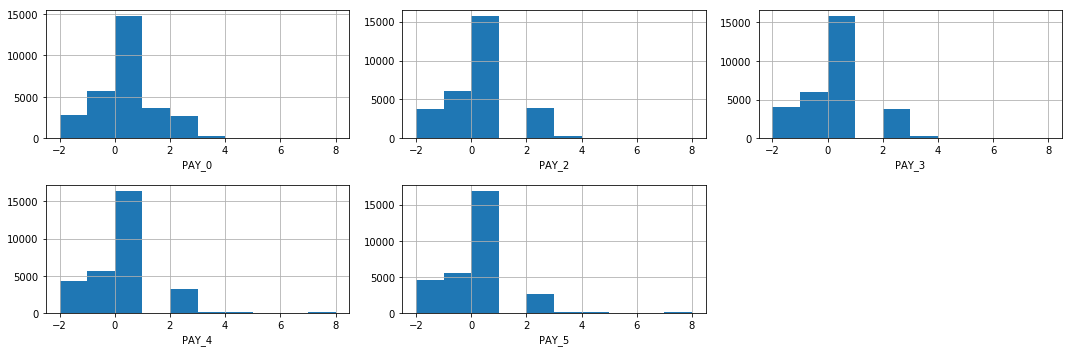

In [5]:
fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.flatten()
main_df['PAY_0'].hist(ax = axs[0])
main_df['PAY_2'].hist(ax = axs[1])
main_df['PAY_3'].hist(ax = axs[2])
main_df['PAY_4'].hist(ax = axs[3])
main_df['PAY_5'].hist(ax = axs[4])
axs[0].set_xlabel("PAY_0")
axs[1].set_xlabel("PAY_2")
axs[2].set_xlabel("PAY_3")
axs[3].set_xlabel("PAY_4")
axs[4].set_xlabel("PAY_5")
fig.delaxes(ax = axs[5])
fig.tight_layout()
fig.show()

0    23364
1     6636
Name: default payment next month, dtype: int64


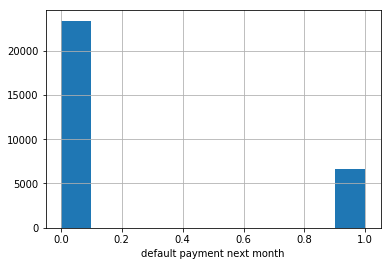

In [6]:
fig, ax = plt.subplots()
ax = main_df['default payment next month'].hist()
ax.set_xlabel('default payment next month')
fig.show()

print(main_df['default payment next month'].value_counts())

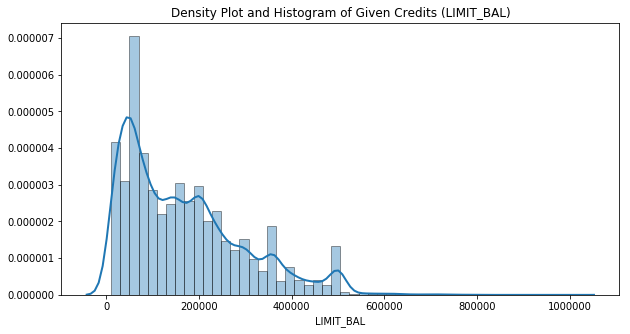

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(main_df['LIMIT_BAL'],hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_title('Density Plot and Histogram of Given Credits (LIMIT_BAL)')
fig.show()

In [8]:
print('Missing values exists = ',main_df.isnull().values.any())
print('Values in Education column are in range (1 - 4) = ',main_df['EDUCATION'].between(1,4, inclusive = True).all())
print('Values in Gender column are in range (1 - 2) = ',main_df['SEX'].between(1,2, inclusive = True).all())
print('Values in Marriage column are in range (0 - 3) = ',main_df['MARRIAGE'].between(0,3, inclusive = True).all())
print('Values in Default Value column are in range (0 - 1) = ',main_df['default payment next month'].between(0,1, inclusive = True).all())
print('Values in Age column are in range (0 - 150) = ',main_df['AGE'].between(0,150, inclusive = True).all())
pay_range = [main_df['PAY_0'].between(-1,9, inclusive = True).all(),
            main_df['PAY_2'].between(-1,9, inclusive = True).all(),
            main_df['PAY_3'].between(-1,9, inclusive = True).all(),
            main_df['PAY_4'].between(-1,9, inclusive = True).all(),
            main_df['PAY_5'].between(-1,9, inclusive = True).all()]
print('Values in Pay columns are in range ((-1) - 9) = ',all(pay_range))

Missing values exists =  False
Values in Education column are in range (1 - 4) =  False
Values in Gender column are in range (1 - 2) =  True
Values in Marriage column are in range (0 - 3) =  True
Values in Default Value column are in range (0 - 1) =  True
Values in Age column are in range (0 - 150) =  True
Values in Pay columns are in range ((-1) - 9) =  False


In [9]:
payment_range = [-1,0,1,2,3,4,5,6,7,8,9]
print('Rows with education value not in range = ',main_df[~main_df['EDUCATION'].isin([1,2,3,4])].shape[0])
print('Rows with PAY_0 value not in range = ',main_df[~main_df['PAY_0'].isin(payment_range)].shape[0])
print('Rows with PAY_2 value not in range = ',main_df[~main_df['PAY_2'].isin(payment_range)].shape[0])
print('Rows with PAY_3 value not in range = ',main_df[~main_df['PAY_3'].isin(payment_range)].shape[0])
print('Rows with PAY_4 value not in range = ',main_df[~main_df['PAY_4'].isin(payment_range)].shape[0])
print('Rows with PAY_5 not in range = ',main_df[~main_df['PAY_5'].isin(payment_range)].shape[0])

Rows with education value not in range =  345
Rows with PAY_0 value not in range =  2759
Rows with PAY_2 value not in range =  3782
Rows with PAY_3 value not in range =  4085
Rows with PAY_4 value not in range =  4348
Rows with PAY_5 not in range =  4546


In [10]:
# Moving unknown educations to other category
main_df.loc[main_df['EDUCATION'] == 0, 'EDUCATION'] = 4
main_df.loc[main_df['EDUCATION'] == 5, 'EDUCATION'] = 4
main_df.loc[main_df['EDUCATION'] == 6, 'EDUCATION'] = 4
print('Rows with education value not in range = ',main_df[~main_df['EDUCATION'].isin([1,2,3,4])].shape[0])

Rows with education value not in range =  0


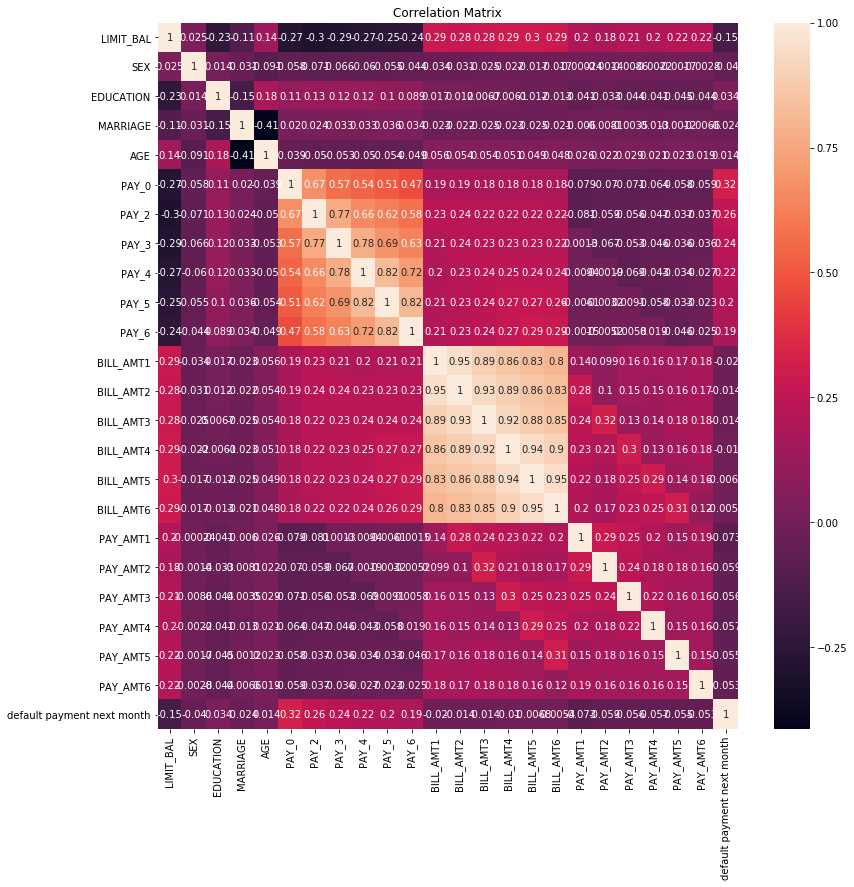

In [11]:
corr = main_df.corr()

fig, ax = plt.subplots(figsize=(13,13))

ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,annot=True)
ax.set_title('Correlation Matrix')
fig.show()

In [12]:
y = main_df['default payment next month']
x = main_df.drop(['default payment next month'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

        knn  randomforest  adaboost  decision
0  0.763232      0.819495  0.819293  0.716869


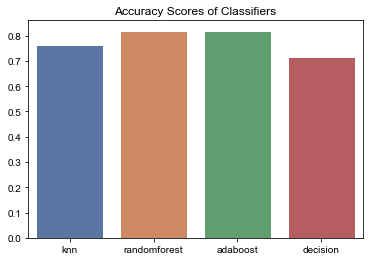

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


clf_decision = DecisionTreeClassifier()
clf_decision.fit(x_train,y_train)
decision_score_acc = clf_decision.score(x_test,y_test)

clf_adaboost = AdaBoostClassifier(n_estimators=50)
clf_adaboost.fit(x_train,y_train)
adaboost_score_acc = clf_adaboost.score(x_test,y_test)

clf_randomforest = RandomForestClassifier(max_depth=5)
clf_randomforest.fit(x_train,y_train)
randomforest_score_acc = clf_randomforest.score(x_test,y_test)

clf_knn = KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(x_train,y_train)
knn_score_acc =clf_knn.score(x_test,y_test)

acc_scores = [knn_score_acc,randomforest_score_acc,adaboost_score_acc,decision_score_acc]
acc_data = pd.DataFrame(acc_scores)
acc_data = acc_data.transpose()
acc_data.columns = ['knn','randomforest','adaboost','decision']

fig, ax = plt.subplots()
sns.set(style="whitegrid")
ax = sns.barplot(data=acc_data)
ax.set_title('Accuracy Scores of Classifiers')
fig.show()

print(acc_data)

f1 scores:
         knn  randomforest  adaboost  decision
0  0.167614      0.459631  0.453072  0.401196 

ROC AUC scores:
         knn  randomforest  adaboost  decision
0  0.529261      0.650066  0.646868  0.612922


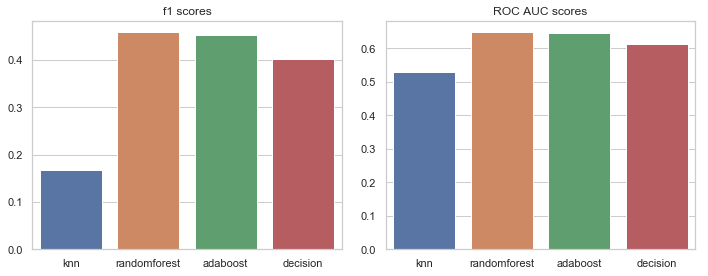

In [14]:
from sklearn.metrics import f1_score,roc_auc_score

knn_predictions = clf_knn.predict(x_test)
randomforest_predictions = clf_randomforest.predict(x_test)
adaboost_predictions = clf_adaboost.predict(x_test)
decision_predictions = clf_decision.predict(x_test)

knn_score_f1 = f1_score(y_test,knn_predictions,average='binary')
randomforest_score_f1 = f1_score(y_test,randomforest_predictions,average='binary')
adaboost_score_f1 = f1_score(y_test,adaboost_predictions,average='binary')
decision_score_f1 = f1_score(y_test,decision_predictions,average='binary')

f1_scores = [knn_score_f1,randomforest_score_f1,adaboost_score_f1,decision_score_f1]

knn_score_auc = roc_auc_score(y_test,knn_predictions)
randomforest_score_auc = roc_auc_score(y_test,randomforest_predictions)
adaboost_score_auc = roc_auc_score(y_test,adaboost_predictions)
decision_score_auc = roc_auc_score(y_test,decision_predictions)

rocauc_scores = [knn_score_auc,randomforest_score_auc,adaboost_score_auc,decision_score_auc]

f1_data = pd.DataFrame(f1_scores)
f1_data = f1_data.transpose()
f1_data.columns = ['knn','randomforest','adaboost','decision']

rocauc_data = pd.DataFrame(rocauc_scores)
rocauc_data = rocauc_data.transpose()
rocauc_data.columns = ['knn','randomforest','adaboost','decision']

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=f1_data,ax=ax[0])
sns.barplot(data=rocauc_data,ax=ax[1])
ax[0].set_title('f1 scores')
ax[1].set_title('ROC AUC scores')
fig.tight_layout()
fig.show()

print('f1 scores:\n', f1_data,'\n\nROC AUC scores:\n',rocauc_data)

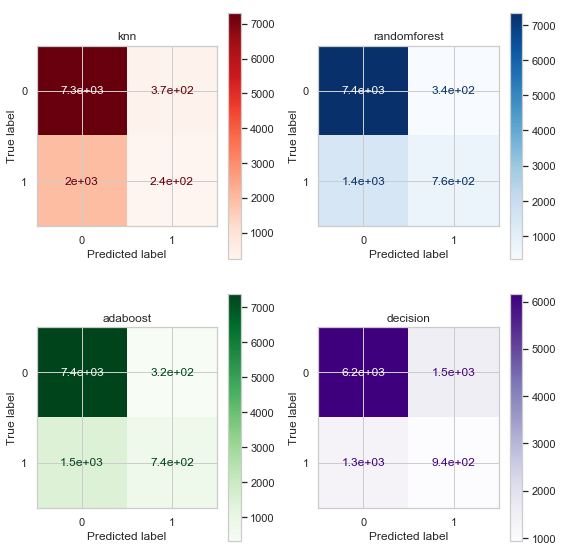

In [15]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(2,2,figsize=(8,8))
ax = ax.flatten()
plot_confusion_matrix(clf_knn, x_test, y_test, cmap=plt.cm.Reds, ax = ax[0])
plot_confusion_matrix(clf_randomforest, x_test, y_test, cmap=plt.cm.Blues, ax = ax[1])
plot_confusion_matrix(clf_adaboost, x_test, y_test, cmap=plt.cm.Greens, ax = ax[2])
plot_confusion_matrix(clf_decision, x_test, y_test, cmap=plt.cm.Purples, ax = ax[3])
ax[0].set_title('knn')
ax[1].set_title('randomforest')
ax[2].set_title('adaboost')
ax[3].set_title('decision')
fig.tight_layout()
fig.show()

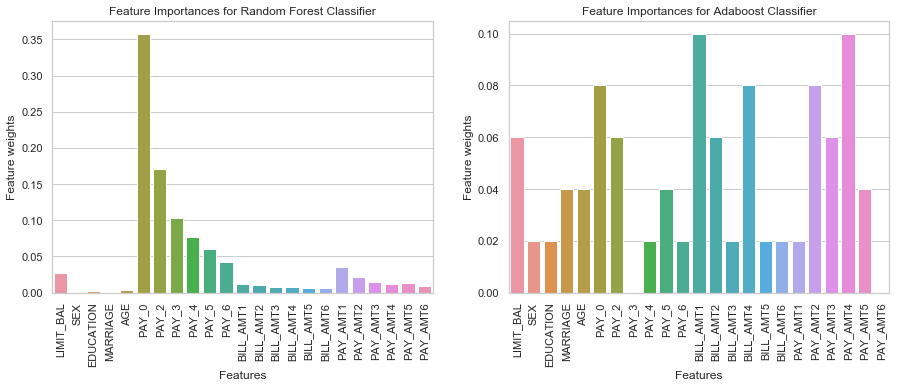

In [16]:
features = x_train.columns.values

weights_randomforest = clf_randomforest.feature_importances_
feature_weights_randomforest = pd.DataFrame(weights_randomforest)
feature_weights_randomforest = feature_weights_randomforest.transpose()
feature_weights_randomforest.columns = features

weights_adaboost = clf_adaboost.feature_importances_
feature_weights_adaboost = pd.DataFrame(weights_adaboost)
feature_weights_adaboost = feature_weights_adaboost.transpose()
feature_weights_adaboost.columns = features

fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.barplot(data=feature_weights_randomforest, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Feature weights')
ax[0].set_title('Feature Importances for Random Forest Classifier')

sns.barplot(data=feature_weights_adaboost, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Feature weights')
ax[1].set_title('Feature Importances for Adaboost Classifier')

fig.show()

In [17]:
one_hot_df = pd.concat([main_df,
                    pd.get_dummies(main_df['SEX'],prefix='sex'),
                    pd.get_dummies(main_df['MARRIAGE'],prefix='marriage'),
                    pd.get_dummies(main_df['EDUCATION'],prefix='education'),
                    pd.get_dummies(main_df['PAY_0'],prefix='pay_0'),
                    pd.get_dummies(main_df['PAY_2'],prefix='pay_2'),
                    pd.get_dummies(main_df['PAY_3'],prefix='pay_3'),
                    pd.get_dummies(main_df['PAY_4'],prefix='pay_4'),
                    pd.get_dummies(main_df['PAY_5'],prefix='pay_5'),
                    pd.get_dummies(main_df['PAY_6'],prefix='pay_6')
                    ] ,axis=1)
one_hot_df = one_hot_df.drop(['SEX','MARRIAGE','EDUCATION','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'],axis=1)
one_hot_df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_6_-2,pay_6_-1,pay_6_0,pay_6_2,pay_6_3,pay_6_4,pay_6_5,pay_6_6,pay_6_7,pay_6_8
1,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
2,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
3,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
4,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
5,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


ONE HOT ENCODED DATAFRAME

f1 scores:
    randomforest  adaboost
0      0.359852  0.458967 

ROC AUC scores:
    randomforest  adaboost
0      0.606266  0.649521


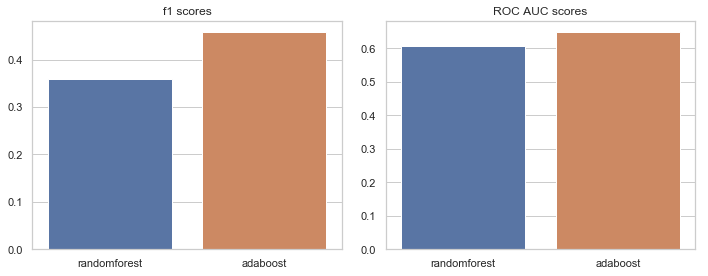

In [18]:
one_hot_y = one_hot_df['default payment next month']
one_hot_x = one_hot_df.drop(['default payment next month'],axis=1)
x_train_oh, x_test_oh, y_train_oh, y_test_oh = train_test_split(one_hot_x, one_hot_y, test_size=0.33)

clf_adaboost.fit(x_train_oh,y_train_oh)
clf_randomforest.fit(x_train_oh,y_train_oh)


randomforest_predictions = clf_randomforest.predict(x_test_oh)
adaboost_predictions = clf_adaboost.predict(x_test_oh)

randomforest_score_f1 = f1_score(y_test_oh,randomforest_predictions,average='binary')
adaboost_score_f1 = f1_score(y_test_oh,adaboost_predictions,average='binary')

randomforest_score_auc = roc_auc_score(y_test_oh,randomforest_predictions)
adaboost_score_auc = roc_auc_score(y_test_oh,adaboost_predictions)

f1_scores = [randomforest_score_f1,adaboost_score_f1]
rocauc_scores = [randomforest_score_auc,adaboost_score_auc]

f1_data = pd.DataFrame(f1_scores)
f1_data = f1_data.transpose()
f1_data.columns = ['randomforest','adaboost']

rocauc_data = pd.DataFrame(rocauc_scores)
rocauc_data = rocauc_data.transpose()
rocauc_data.columns = ['randomforest','adaboost']

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=f1_data,ax=ax[0])
sns.barplot(data=rocauc_data,ax=ax[1])
ax[0].set_title('f1 scores')
ax[1].set_title('ROC AUC scores')
fig.tight_layout()
fig.show()

print('ONE HOT ENCODED DATAFRAME\n')
print('f1 scores:\n', f1_data,'\n\nROC AUC scores:\n',rocauc_data)

In [19]:
pay_perc_1 = []
pay_perc_2 = []
pay_perc_3 = []
pay_perc_4 = []
pay_perc_5 = []
pay_perc_6 = []

for i in main_df.index:
    if main_df['BILL_AMT1'][i] <= 0:
        pay_perc_1.append(50)
    else:
        a = (main_df['PAY_AMT1'][i] * 100) / main_df['BILL_AMT1'][i]
        pay_perc_1.append(int(a))
        
    if main_df['BILL_AMT2'][i] <= 0:
        pay_perc_2.append(50)
    else:
        a = (main_df['PAY_AMT2'][i] * 100) / main_df['BILL_AMT2'][i]
        pay_perc_2.append(int(a))
        
    if main_df['BILL_AMT3'][i] <= 0:
        pay_perc_3.append(50)
    else:
        a = (main_df['PAY_AMT3'][i] * 100) / main_df['BILL_AMT3'][i]
        pay_perc_3.append(int(a))
        
    if main_df['BILL_AMT4'][i] <= 0:
        pay_perc_4.append(50)
    else:
        a = (main_df['PAY_AMT4'][i] * 100) / main_df['BILL_AMT4'][i]
        pay_perc_4.append(int(a))
    
    if main_df['BILL_AMT5'][i] <= 0:
        pay_perc_5.append(50)
    else:
        a = (main_df['PAY_AMT5'][i] * 100) / main_df['BILL_AMT5'][i]
        pay_perc_5.append(int(a))
        
    if main_df['BILL_AMT6'][i] <= 0:
        pay_perc_6.append(50)
    else:
        a = (main_df['PAY_AMT6'][i] * 100) / main_df['BILL_AMT6'][i]
        pay_perc_6.append(int(a))

DATAFRAME WITH PAY PERCENTAGE FEATURES

f1 scores:
    randomforest  adaboost
0      0.426768  0.431925 

ROC AUC scores:
    randomforest  adaboost
0      0.634866   0.63724


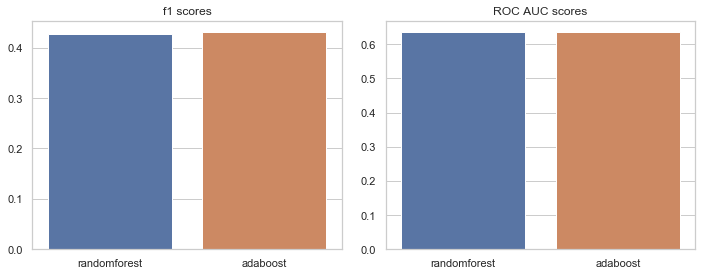

In [20]:
df_new_features = pd.concat([pd.DataFrame(pay_perc_1),
                            pd.DataFrame(pay_perc_2),
                            pd.DataFrame(pay_perc_3),
                            pd.DataFrame(pay_perc_4),
                            pd.DataFrame(pay_perc_5),
                            pd.DataFrame(pay_perc_6)],axis=1)
df_new_features.columns = ['pay_perc1','pay_perc2','pay_perc3','pay_perc4','pay_perc5','pay_perc6']
main_df_with_new_features = pd.concat([main_df.reset_index(),df_new_features],axis=1,ignore_index=True)

new_y = main_df_with_new_features.iloc[:,24:25]
new_x = main_df_with_new_features.drop([24],axis=1)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(new_x, new_y, test_size=0.33)

clf_adaboost.fit(x_train_new,y_train_new)
clf_randomforest.fit(x_train_new,y_train_new)

randomforest_predictions = clf_randomforest.predict(x_test_new)
adaboost_predictions = clf_adaboost.predict(x_test_new)

randomforest_score_f1 = f1_score(y_test_new,randomforest_predictions,average='binary')
adaboost_score_f1 = f1_score(y_test_new,adaboost_predictions,average='binary')

randomforest_score_auc = roc_auc_score(y_test_new,randomforest_predictions)
adaboost_score_auc = roc_auc_score(y_test_new,adaboost_predictions)

f1_scores = [randomforest_score_f1,adaboost_score_f1]
rocauc_scores = [randomforest_score_auc,adaboost_score_auc]

f1_data = pd.DataFrame(f1_scores)
f1_data = f1_data.transpose()
f1_data.columns = ['randomforest','adaboost']

rocauc_data = pd.DataFrame(rocauc_scores)
rocauc_data = rocauc_data.transpose()
rocauc_data.columns = ['randomforest','adaboost']

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=f1_data,ax=ax[0])
sns.barplot(data=rocauc_data,ax=ax[1])
ax[0].set_title('f1 scores')
ax[1].set_title('ROC AUC scores')
fig.tight_layout()
fig.show()

print('DATAFRAME WITH PAY PERCENTAGE FEATURES\n')
print('f1 scores:\n', f1_data,'\n\nROC AUC scores:\n',rocauc_data)

DATAFRAME WITH PAY SLOPE FEATURE

f1 scores:
    randomforest  adaboost
0      0.461771  0.447616 

ROC AUC scores:
    randomforest  adaboost
0      0.651337   0.64447


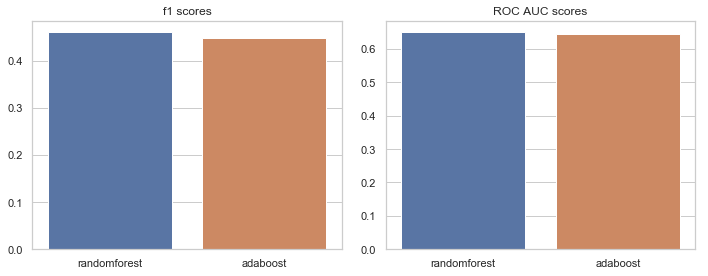

In [21]:
pay_slopes=[]
for i in main_df.index:
    data = [main_df['PAY_0'][i],main_df['PAY_2'][i],main_df['PAY_3'][i],main_df['PAY_4'][i],main_df['PAY_5'][i]]
    list_of_index=[0,1,2,3,4]
    result = np.polyfit(list_of_index, list(data), 1)
    pay_slopes.append(result[-2])
df_with_payslopes = pd.concat([main_df.reset_index(),pd.DataFrame(pay_slopes)],axis=1)

df_payslope_y = df_with_payslopes['default payment next month']
df_payslope_x = df_with_payslopes.drop(['default payment next month'],axis=1)
x_train_ps, x_test_ps, y_train_ps, y_test_ps = train_test_split(df_payslope_x, df_payslope_y, test_size=0.33)

clf_adaboost.fit(x_train_ps,y_train_ps)
clf_randomforest.fit(x_train_ps,y_train_ps)


randomforest_predictions = clf_randomforest.predict(x_test_ps)
adaboost_predictions = clf_adaboost.predict(x_test_ps)

randomforest_score_f1 = f1_score(y_test_ps,randomforest_predictions,average='binary')
adaboost_score_f1 = f1_score(y_test_ps,adaboost_predictions,average='binary')

randomforest_score_auc = roc_auc_score(y_test_ps,randomforest_predictions)
adaboost_score_auc = roc_auc_score(y_test_ps,adaboost_predictions)

f1_scores = [randomforest_score_f1,adaboost_score_f1]
rocauc_scores = [randomforest_score_auc,adaboost_score_auc]

f1_data = pd.DataFrame(f1_scores)
f1_data = f1_data.transpose()
f1_data.columns = ['randomforest','adaboost']

rocauc_data = pd.DataFrame(rocauc_scores)
rocauc_data = rocauc_data.transpose()
rocauc_data.columns = ['randomforest','adaboost']

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=f1_data,ax=ax[0])
sns.barplot(data=rocauc_data,ax=ax[1])
ax[0].set_title('f1 scores')
ax[1].set_title('ROC AUC scores')
fig.tight_layout()
fig.show()

print('DATAFRAME WITH PAY SLOPE FEATURE\n')
print('f1 scores:\n', f1_data,'\n\nROC AUC scores:\n',rocauc_data)

In [22]:
downsample_df = main_df
random_samples = downsample_df[downsample_df['default payment next month'] == 0].sample(
    n=main_df['default payment next month'].value_counts()[0] - main_df['default payment next month'].value_counts()[1])

downsample_df = downsample_df.drop(random_samples.index.tolist())
print(downsample_df['default payment next month'].value_counts())

1    6636
0    6636
Name: default payment next month, dtype: int64


DOWNSAMPLED DATAFRAME

f1 scores:
    randomforest  adaboost
0      0.694881  0.676635 

ROC AUC scores:
    randomforest  adaboost
0       0.72375  0.707308
Accuracy scores:
Randomforest=  0.7251141552511415 
Adaboost=  0.708675799086758


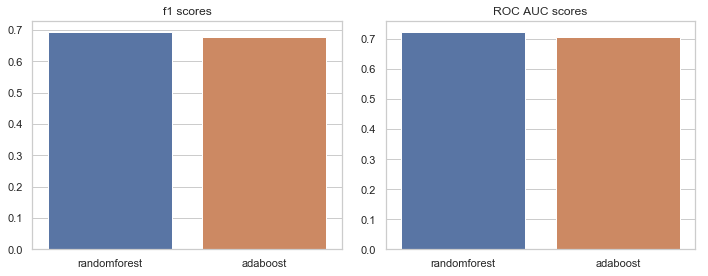

In [23]:
ds_y = downsample_df['default payment next month']
ds_x = downsample_df.drop(['default payment next month'],axis=1)
x_train_ds, x_test_ds, y_train_ds, y_test_ds = train_test_split(ds_x, ds_y, test_size=0.33)

clf_adaboost.fit(x_train_ds,y_train_ds)
clf_randomforest.fit(x_train_ds,y_train_ds)

randomforest_predictions = clf_randomforest.predict(x_test_ds)
adaboost_predictions = clf_adaboost.predict(x_test_ds)

randomforest_score_f1 = f1_score(y_test_ds,randomforest_predictions,average='binary')
adaboost_score_f1 = f1_score(y_test_ds,adaboost_predictions,average='binary')

randomforest_score_auc = roc_auc_score(y_test_ds,randomforest_predictions)
adaboost_score_auc = roc_auc_score(y_test_ds,adaboost_predictions)

f1_scores = [randomforest_score_f1,adaboost_score_f1]
rocauc_scores = [randomforest_score_auc,adaboost_score_auc]

f1_data = pd.DataFrame(f1_scores)
f1_data = f1_data.transpose()
f1_data.columns = ['randomforest','adaboost']

rocauc_data = pd.DataFrame(rocauc_scores)
rocauc_data = rocauc_data.transpose()
rocauc_data.columns = ['randomforest','adaboost']

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=f1_data,ax=ax[0])
sns.barplot(data=rocauc_data,ax=ax[1])
ax[0].set_title('f1 scores')
ax[1].set_title('ROC AUC scores')
fig.tight_layout()
fig.show()

print('DOWNSAMPLED DATAFRAME\n')
print('f1 scores:\n', f1_data,'\n\nROC AUC scores:\n',rocauc_data)

randomforest_score_acc = clf_randomforest.score(x_test_ds,y_test_ds)
adaboost_score_acc = clf_adaboost.score(x_test_ds,y_test_ds)

print('Accuracy scores:\nRandomforest= ',randomforest_score_acc,'\nAdaboost= ',adaboost_score_acc)

In [24]:
pay_slopes=[]
downsample_df = downsample_df.reset_index()
for i in downsample_df.index:
    data = [downsample_df['PAY_0'][i],downsample_df['PAY_2'][i],downsample_df['PAY_3'][i],downsample_df['PAY_4'][i],downsample_df['PAY_5'][i]]
    list_of_index=[0,1,2,3,4]
    result = np.polyfit(list_of_index, list(data), 1)
    pay_slopes.append(result[-2])
df_with_payslopes_ds = pd.concat([downsample_df,pd.DataFrame(pay_slopes,columns=['ps'])],axis=1)

DOWNSAMPLED DATAFRAME WITH PAY SLOPE FEATURE

f1 scores:
    randomforest  adaboost
0      0.651101  0.660541 

ROC AUC scores:
    randomforest  adaboost
0      0.698441  0.695358
Accuracy scores:
Randomforest=  0.6997716894977168 
Adaboost=  0.6963470319634704


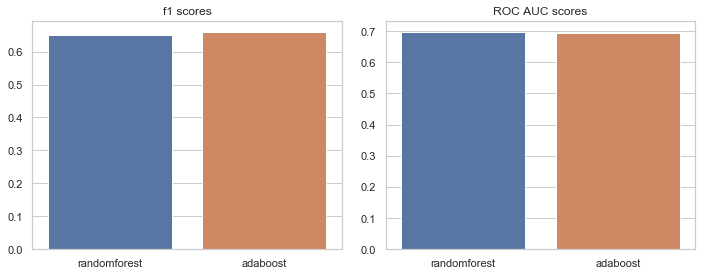

In [25]:
ds_y = df_with_payslopes_ds['default payment next month']
ds_x = df_with_payslopes_ds.drop(['default payment next month'],axis=1)
x_train_ds, x_test_ds, y_train_ds, y_test_ds = train_test_split(ds_x, ds_y, test_size=0.33)

clf_adaboost.fit(x_train_ds,y_train_ds)
clf_randomforest.fit(x_train_ds,y_train_ds)

randomforest_predictions = clf_randomforest.predict(x_test_ds)
adaboost_predictions = clf_adaboost.predict(x_test_ds)

randomforest_score_f1 = f1_score(y_test_ds,randomforest_predictions,average='binary')
adaboost_score_f1 = f1_score(y_test_ds,adaboost_predictions,average='binary')

randomforest_score_auc = roc_auc_score(y_test_ds,randomforest_predictions)
adaboost_score_auc = roc_auc_score(y_test_ds,adaboost_predictions)

f1_scores = [randomforest_score_f1,adaboost_score_f1]
rocauc_scores = [randomforest_score_auc,adaboost_score_auc]

f1_data = pd.DataFrame(f1_scores)
f1_data = f1_data.transpose()
f1_data.columns = ['randomforest','adaboost']

rocauc_data = pd.DataFrame(rocauc_scores)
rocauc_data = rocauc_data.transpose()
rocauc_data.columns = ['randomforest','adaboost']

fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.set(style="whitegrid")
sns.barplot(data=f1_data,ax=ax[0])
sns.barplot(data=rocauc_data,ax=ax[1])
ax[0].set_title('f1 scores')
ax[1].set_title('ROC AUC scores')
fig.tight_layout()
fig.show()

print('DOWNSAMPLED DATAFRAME WITH PAY SLOPE FEATURE\n')
print('f1 scores:\n', f1_data,'\n\nROC AUC scores:\n',rocauc_data)

randomforest_score_acc = clf_randomforest.score(x_test_ds,y_test_ds)
adaboost_score_acc = clf_adaboost.score(x_test_ds,y_test_ds)

print('Accuracy scores:\nRandomforest= ',randomforest_score_acc,'\nAdaboost= ',adaboost_score_acc)